## Patient-level data split for all cohorts

In [1]:
# import packages

import pandas as pd
import numpy as np
#import random
import matplotlib.pyplot as plt
#import seaborn as sns
from altair import *
#from google.cloud import bigquery
from deep_nexus.preprocess_images import random_split

In [2]:
# the following cell is to generate a dataframe containing slides information
# take CHOL with higher than 95% purity as an example

In [3]:
%%bigquery df
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND (sample_type_name='Solid Tissue Normal' OR (sample_type_name='Primary solid Tumor' AND avg_percent_tumor_cells>95))

In [4]:
# add mutation_states and check df

df['mutation_states'] = np.nan
df.head()

,case_barcode,sample_barcode,disease_code,sample_type_name,avg_percent_tumor_cells,file_gcs_url,mutation_states
0,TCGA-N5-A59E,TCGA-N5-A59E-01A,UCS,Primary solid Tumor,100.0,gs://gdc-tcga-phs000178-open/5c3db5b8-480d-465...,NaN
1,TCGA-N5-A4RV,TCGA-N5-A4RV-01A,UCS,Primary solid Tumor,100.0,gs://gdc-tcga-phs000178-open/7a1456b4-bd25-49a...,NaN
2,TCGA-FF-8047,TCGA-FF-8047-01A,DLBC,Primary solid Tumor,100.0,gs://gdc-tcga-phs000178-open/d4f59c98-5c11-4b4...,NaN
3,TCGA-FF-8047,TCGA-FF-8047-01A,DLBC,Primary solid Tumor,100.0,gs://gdc-tcga-phs000178-open/3fb3733a-71c6-467...,NaN
4,TCGA-G8-6914,TCGA-G8-6914-01A,DLBC,Primary solid Tumor,100.0,gs://gdc-tcga-phs000178-open/00bb08da-d796-47a...,NaN


In [5]:
# do patient-level data split
# random_split function receives a dataframe df containing slide_id and patient_id
# train and valid ratio are set to 0.70 and 0.15 as default
# seed is set to 42 as default

train_df, test_df, valid_df = random_split(df, train_prop = 0.70, test_prop = 0.15, valid_prop = 0.15, seed = 42)

The length of train_df: 3700.
The length of test_df: 783.
The length of valid_df: 785.


In [6]:
# get sample barcodes

train_slide = list(train_df['sample_barcode'])
test_slide = list(test_df['sample_barcode'])
valid_slide = list(valid_df['sample_barcode'])

### If we discard tumor slides with purity no more than 95, get discarded slide IDs.

In [7]:
%%bigquery df_rest
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND sample_type_name='Primary solid Tumor' AND avg_percent_tumor_cells<=95
ORDER BY avg_percent_tumor_cells

In [8]:
df_rest['mutation_states'] = np.nan
df_rest.head()

,case_barcode,sample_barcode,disease_code,sample_type_name,avg_percent_tumor_cells,file_gcs_url,mutation_states
0,TCGA-HC-8265,TCGA-HC-8265-01A,PRAD,Primary solid Tumor,0.0,gs://gdc-tcga-phs000178-open/c5c286cd-5f70-498...,NaN
1,TCGA-HC-8260,TCGA-HC-8260-01A,PRAD,Primary solid Tumor,0.0,gs://gdc-tcga-phs000178-open/1790abdd-08a3-4b5...,NaN
2,TCGA-HC-8266,TCGA-HC-8266-01A,PRAD,Primary solid Tumor,0.0,gs://gdc-tcga-phs000178-open/1ee5d7aa-d100-457...,NaN
3,TCGA-55-8206,TCGA-55-8206-01A,LUAD,Primary solid Tumor,0.0,gs://gdc-tcga-phs000178-open/b89b673b-b84e-406...,NaN
4,TCGA-55-8205,TCGA-55-8205-01A,LUAD,Primary solid Tumor,0.0,gs://gdc-tcga-phs000178-open/e9091669-3b27-42c...,NaN


In [9]:
slide_rest = list(df_rest['sample_barcode'])
len(slide_rest)

12361

### Or, we can include those discarded slides in the test and validation sets.

In [10]:
%%bigquery df_full
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND (sample_type_name='Primary solid Tumor' OR sample_type_name='Solid Tissue Normal')

In [11]:
df_full['mutation_states'] = np.nan
df_full.head()

,case_barcode,sample_barcode,disease_code,sample_type_name,avg_percent_tumor_cells,file_gcs_url,mutation_states
0,TCGA-A8-A06U,TCGA-A8-A06U-01A,BRCA,Primary solid Tumor,57.5,gs://gdc-tcga-phs000178-open/c31b1184-ec81-441...,NaN
1,TCGA-CR-7383,TCGA-CR-7383-01A,HNSC,Primary solid Tumor,63.0,gs://gdc-tcga-phs000178-open/b3bfd15d-8ae0-4e8...,NaN
2,TCGA-CR-7401,TCGA-CR-7401-01A,HNSC,Primary solid Tumor,78.0,gs://gdc-tcga-phs000178-open/426829db-fa6c-465...,NaN
3,TCGA-CR-7364,TCGA-CR-7364-01A,HNSC,Primary solid Tumor,88.0,gs://gdc-tcga-phs000178-open/317bd2c1-2649-42d...,NaN
4,TCGA-CR-7377,TCGA-CR-7377-01A,HNSC,Primary solid Tumor,68.0,gs://gdc-tcga-phs000178-open/297312b3-2c88-419...,NaN


#### 1. Check purity distribution.

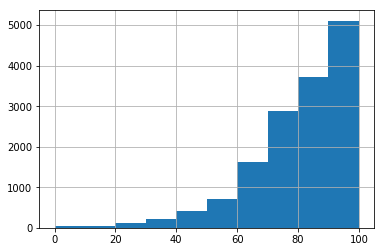

In [12]:
df_full[df_full.sample_type_name=='Primary solid Tumor'].avg_percent_tumor_cells.hist()

#### 2. Reset purity threshold to balance the size of train/test/valid.

In [13]:
%%bigquery df_60
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND (sample_type_name='Solid Tissue Normal' OR (sample_type_name='Primary solid Tumor' AND avg_percent_tumor_cells>60))

In [14]:
%%bigquery df_60_rest
SELECT case_barcode, sample_barcode, disease_code, sample_type_name, avg_percent_tumor_cells, file_gcs_url
FROM `deep-nexus.tcga.TCGA_slides_metadata`
WHERE is_ffpe ='NO' AND sample_type_name='Primary solid Tumor' AND avg_percent_tumor_cells<=60

In [15]:
df_60['mutation_states'] = np.nan
df_60_rest['mutation_states'] = np.nan

In [16]:
train_df_60, test_df_part1, valid_df_part1 = random_split(df_60, train_prop = 0.70, test_prop = 0.15, valid_prop = 0.15, seed = 42)

The length of train_df: 10731.
The length of test_df: 2347.
The length of valid_df: 2363.


In [17]:
_, test_df_part2, valid_df_part2 = random_split(df_60_rest, train_prop = 0, test_prop = 0.5, valid_prop = 0.5, seed = 42)

The length of train_df: 0.
The length of test_df: 1078.
The length of valid_df: 1110.


In [18]:
test_df_60 = pd.concat([test_df_part1, test_df_part2], ignore_index=True)
valid_df_60 = pd.concat([valid_df_part1, valid_df_part2], ignore_index=True)

#### 3. Check if `case_barcode` in test & valid sets do not show in train set, otherwise move overlapping ones.

In [19]:
train_case = list(pd.unique(train_df_60['case_barcode']))
test_case = list(pd.unique(test_df_60['case_barcode']))
valid_case = list(pd.unique(valid_df_60['case_barcode']))

In [20]:
len(train_case), len(test_case), len(valid_case)

(6326, 2182, 2178)

In [21]:
test_case_final = [case for case in test_case if case not in train_case]
valid_case_final = [case for case in valid_case if case not in train_case]

In [22]:
len(test_case_final), len(valid_case_final)

(2075, 2088)

In [23]:
test_df_60 = test_df_60[test_df_60['case_barcode'].isin(test_case_final)]
valid_df_60 = valid_df_60[valid_df_60['case_barcode'].isin(valid_case_final)]

In [24]:
train_slide_60 = list(train_df_60['sample_barcode'])
test_slide_60 = list(test_df_60['sample_barcode'])
valid_slide_60 = list(valid_df_60['sample_barcode'])

In [25]:
print("train set, length = {}".format(len(train_slide_60)))
#print(train_slide_60)
print("test set, length = {}".format(len(test_slide_60)))
#print(test_slide_60)
print("valid set, length = {}".format(len(valid_slide_60)))
#print(valid_slide_60)

train set, length = 10731
test set, length = 3263
valid set, length = 3336


#### 4. Combine three datasets and push the dataframe to BigQuery.

In [26]:
train_df_60['dataset'] = 'train'
test_df_60['dataset'] = 'test'
valid_df_60['dataset'] = 'valid'

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [27]:
train_test_valid = pd.concat([train_df_60, test_df_60, valid_df_60], ignore_index=True)
train_test_valid.head()

,case_barcode,sample_barcode,disease_code,sample_type_name,avg_percent_tumor_cells,file_gcs_url,mutation_states,dataset
0,TCGA-CR-7383,TCGA-CR-7383-01A,HNSC,Primary solid Tumor,63.0,gs://gdc-tcga-phs000178-open/b3bfd15d-8ae0-4e8...,NaN,train
1,TCGA-CR-7401,TCGA-CR-7401-01A,HNSC,Primary solid Tumor,78.0,gs://gdc-tcga-phs000178-open/426829db-fa6c-465...,NaN,train
2,TCGA-CR-7380,TCGA-CR-7380-01A,HNSC,Primary solid Tumor,88.0,gs://gdc-tcga-phs000178-open/e9e69f97-f978-498...,NaN,train
3,TCGA-CR-7390,TCGA-CR-7390-01A,HNSC,Primary solid Tumor,88.0,gs://gdc-tcga-phs000178-open/df725c90-28f9-44c...,NaN,train
4,TCGA-AN-A0G0,TCGA-AN-A0G0-01A,BRCA,Primary solid Tumor,86.5,gs://gdc-tcga-phs000178-open/1b06f985-d109-430...,NaN,train


In [28]:
train_test_valid.to_gbq('tcga.train_test_valid', 'deep-nexus', if_exists='replace')

1it [00:05,  5.30s/it]


#### 5. Plot tumor vs normal.

In [29]:
train_type = train_df_60['sample_type_name'].value_counts()
test_type = test_df_60['sample_type_name'].value_counts()
valid_type = valid_df_60['sample_type_name'].value_counts()

In [30]:
df_type = pd.DataFrame([train_type, test_type, valid_type], index=['train', 'test', 'valid'])
df_type

,Primary solid Tumor,Solid Tissue Normal
train,8842,1889
test,2841,422
valid,2896,440


#### 5.1 tumor/normal in each dataset

Text(0.5, 1.0, 'Tumor/normal slides ditribution in each dataset')

<Figure size 720x432 with 0 Axes>

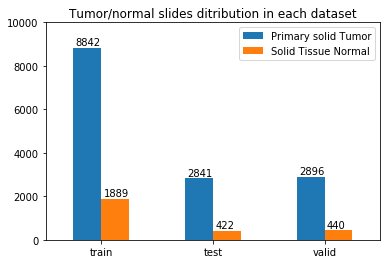

In [31]:
plt.figure(figsize=(10, 6))
ax = df_type.plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.02, p.get_height()+100))
plt.ylim(0,10000)
plt.xticks(rotation=0)
plt.title('Tumor/normal slides ditribution in each dataset')

#### 5.2 tumor/normal in each cohort

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

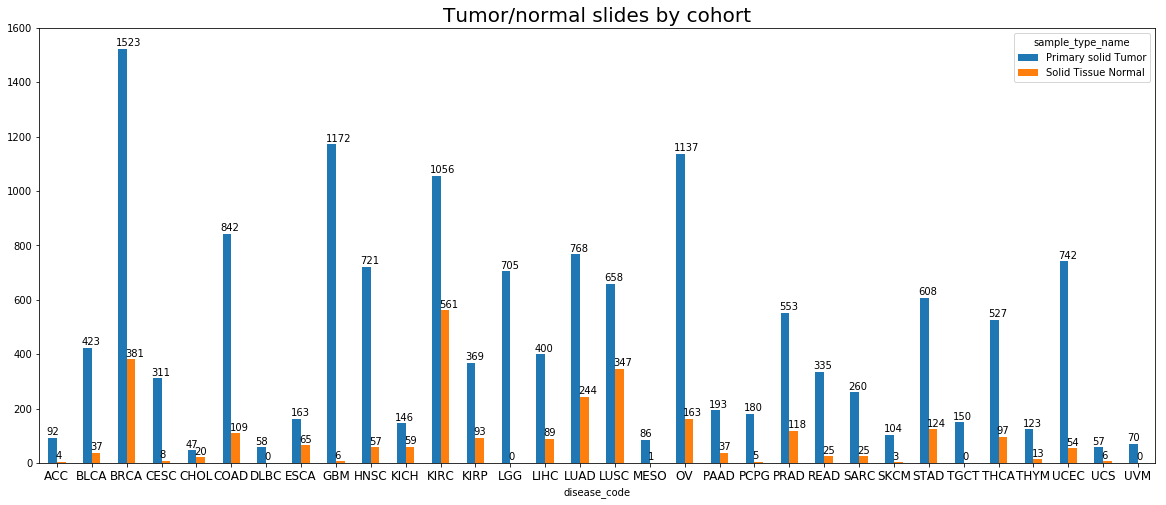

In [32]:
ax = train_test_valid.groupby(['disease_code', 'sample_type_name']).size().unstack(fill_value=0).plot(kind='bar', figsize=(20,8))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.05, p.get_height()+10))
plt.title('Tumor/normal slides by cohort', size=20)
plt.xticks(rotation=0, size=12)

#### 5.3 tumor/normal in each cohort, stacked bar chart
**1) ungrouped by `disease_code`**

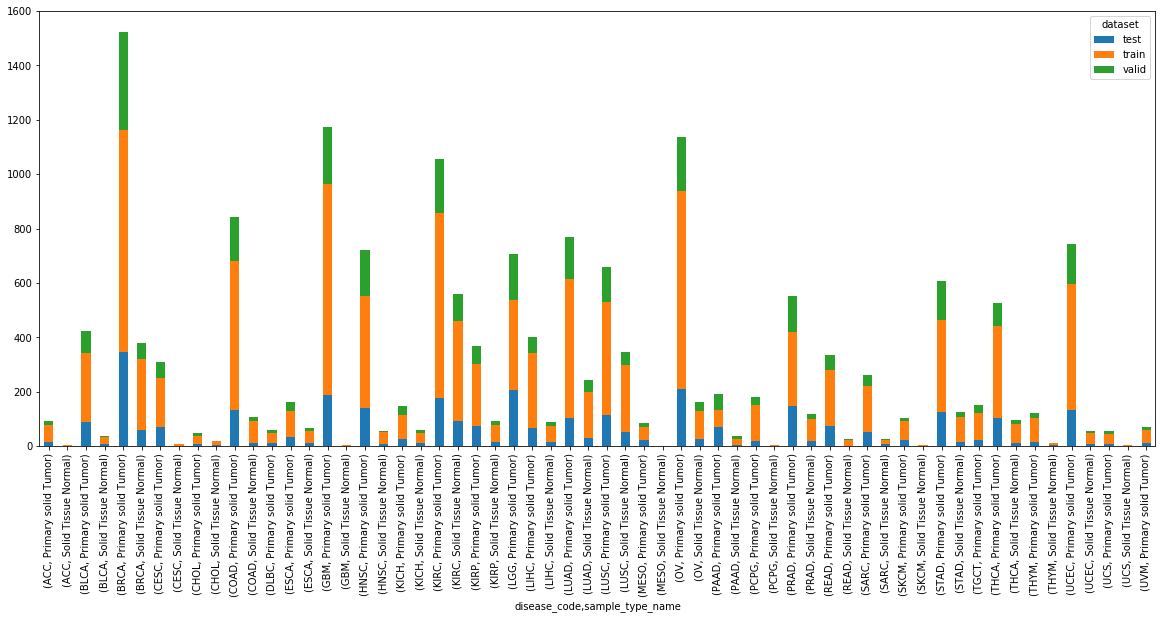

In [33]:
train_test_valid.groupby(['disease_code', 'sample_type_name', 'dataset']).size().unstack(fill_value=0).plot(kind='bar', stacked=True, figsize=(20,8))

**2) grouped by `disease_code`**

Ref: https://github.com/altair-viz/altair/issues/1679, https://altair-viz.github.io/gallery/grouped_bar_chart.html, https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars-with-python-pandas

In [34]:
value_count = train_test_valid.groupby(['disease_code', 'sample_type_name', 'dataset']).size().reset_index(name='values')
value_count.replace('Primary solid Tumor', 'tumor', inplace=True)
value_count.replace('Solid Tissue Normal', 'normal', inplace=True)
value_count.replace('train', '1-train', inplace=True)
value_count.replace('valid', '2-valid', inplace=True)
value_count.replace('test', '3-test', inplace=True)
value_count.columns = ['disease_code', 'type', 'dataset', 'values']
value_count.head()

,disease_code,type,dataset,values
0,ACC,tumor,3-test,16
1,ACC,tumor,1-train,61
2,ACC,tumor,2-valid,15
3,ACC,normal,1-train,3
4,ACC,normal,2-valid,1


In [35]:
Chart(value_count).mark_bar().encode(x='type:N',y=Y('values', axis=Axis(grid=True)), column=Column('disease_code:N'), color='dataset:N')

alt.Chart(...)

The above chart may not show in GitHub. Please visit "tumor_normal_stacked_bar.svg".